In [3]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score

In [4]:
train_valid = np.load('all_oof.npy')
test_preds = np.load('all_test_preds.npy')
indexes = np.load('indexes_shuffled.npy')

In [5]:
train_path = '../../datasets/santander_customer_transaction_prediction/train.csv'

In [6]:
y_train = pd.read_csv(train_path)['target'].values[indexes]

In [7]:
train_valid.shape

(200000, 200)

In [9]:
roc_auc_score(y_train, train_valid[:, :40].sum(axis=1))

0.5916024965567686

# Regresión logística

In [6]:
train_valid_norm = (train_valid - train_valid.mean(axis=0))/train_valid.std(axis=0)

In [7]:
train_valid_intercept = np.append(train_valid_norm, np.ones((200000,1)), axis=1)

In [99]:
# ENSEMBLE MODEL WITH MAGIC
logr = sm.Logit(y_train, train_valid_intercept)
%time logr = logr.fit(disp=1, method='newton')
ensemble_preds = logr.predict(train_valid_intercept)
ensemble_auc = roc_auc_score(y_train, ensemble_preds)  
print('##################')
print('Combined Model with magic Val_AUC=',round(ensemble_auc,5))
print()

Optimization terminated successfully.
         Current function value: 0.180549
         Iterations 8
CPU times: user 10.7 s, sys: 594 ms, total: 11.3 s
Wall time: 1.88 s
##################
Combined Model with magic Val_AUC= 0.92011



In [106]:
test_preds_norm = (test_preds - test_preds.mean(axis=0))/test_preds.std(axis=0)
test_preds_intercept = np.append(test_preds_norm, np.ones((200000,1)), axis=1)
test_predictions = logr.predict(test_preds_intercept)

In [110]:
np.max(test_predictions)

1.0

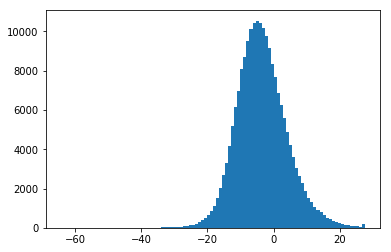

In [111]:
from matplotlib import pyplot as plt
_=plt.hist(np.log(test_predictions/(1-test_predictions+1e-12)), 100)

In [167]:
#logr.params

# Red neuronal

In [263]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam, SGD
from keras.layers import Dropout, BatchNormalization

In [286]:
model = Sequential()
model.add(Dense( 4, input_shape=(train_valid.shape[1],), activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))
model.add(Dense( 1, input_shape=(train_valid.shape[1],), activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_38 (Dense)             (None, 4)                 804       
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 5         
Total params: 809
Trainable params: 809
Non-trainable params: 0
_________________________________________________________________


In [287]:
model.compile(Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [288]:
N = 160_000

In [289]:
model.fit(train_valid_norm[:N], y_train[:N], 
          epochs=20, batch_size=500, 
          validation_data=(train_valid_norm[N:], y_train[N:]))

Train on 160000 samples, validate on 40000 samples
Epoch 1/20
160000/160000 [==============================] - 1s 8us/step - loss: 0.3605 - acc: 0.8896 - val_loss: 0.7967 - val_acc: 0.4917
Epoch 2/20
160000/160000 [==============================] - 1s 4us/step - loss: 0.2860 - acc: 0.9244 - val_loss: 0.5451 - val_acc: 0.8619
Epoch 3/20
160000/160000 [==============================] - 1s 4us/step - loss: 0.2643 - acc: 0.9266 - val_loss: 0.4502 - val_acc: 0.9166
Epoch 4/20
160000/160000 [==============================] - 1s 5us/step - loss: 0.2476 - acc: 0.9280 - val_loss: 0.3956 - val_acc: 0.9205
Epoch 5/20
160000/160000 [==============================] - 1s 4us/step - loss: 0.2346 - acc: 0.9290 - val_loss: 0.3560 - val_acc: 0.9198
Epoch 6/20
160000/160000 [==============================] - 1s 4us/step - loss: 0.2244 - acc: 0.9297 - val_loss: 0.3267 - val_acc: 0.9184
Epoch 7/20
160000/160000 [==============================] - 1s 4us/step - loss: 0.2166 - acc: 0.9305 - val_loss: 0.3045 -

In [255]:
roc_auc_score(y_train[:N], model.predict_proba(train_valid_norm[:N], verbose=1))

160000/160000 [==============================] - 2s 12us/step


0.9269020992900272

In [256]:
roc_auc_score(y_train[N:], model.predict_proba(train_valid_norm[N:], verbose=1))

40000/40000 [==============================] - 0s 11us/step


0.9036660912312631

In [239]:
model.evaluate(train_valid_norm[:N], y_train[:N])

160000/160000 [==============================] - 2s 15us/step


[0.17889474597238003, 0.93409375]

In [240]:
model.evaluate(train_valid_norm[N:], y_train[N:])

40000/40000 [==============================] - 1s 20us/step


[0.6072848263263703, 0.92105]